<a href="https://colab.research.google.com/github/Anna172/Python/blob/master/MF_DFA_%D0%B4%D0%B72.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MF_DFA**
Home task №2

Анна Трушникова ББИ172

Данные все те же: https://www.federalreserve.gov/datadownload/Download.aspx?rel=H10&series=a3220d269bb3c9c5e2fffa49160c8cdf&filetype=csv&label=include&layout=seriescolumn&lastObs=10

## Теория

Пусть есть временной ряд из $N$ наблюдений:

$$ \{x_i\} = (x_0, x_1, \dots, x_{N-1}) $$

1. Для исходного временного ряда $\{x_i\}$ строится временной ряд, приведенный к среднему $\bar{x}$:
  $$ \bar{x} = \frac{1}{N} \sum_{i=1}^N x_i$$
  
  $$ \tilde{x}_i = x_i - \bar{x}$$
  
2. Из ряда $\{\tilde{x}_i\}$ формируется глобальный профиль (кумулятивная сумма):

  $$ Y(j) = \sum_{i=1}^j \tilde{x}_i,\quad j = 0, 1, 2, \dots, N-1$$

3. Глобальный профиль разбивается на смежные отрезки $Y_v (j)$длиной $s$ с индексами $v = 0, 1, 2, \dots, N_s-1$, где $ N_s = \lfloor N/s \rfloor$.

  Так как длина ряда $N$ не всегда кратна выбранной шкале $s$, то в общем случае последний участок содержит число точек, меньше чем $s$. Для учета этого остатка следует повторить процедуру деления на сегменты, начиная с противоположного конца ряда. В результате полное число сегментов, имеющих длину $s$, составит $N_s = 2 \lfloor N/s \rfloor$.

4.  Для каждого сегмента находим локальный тренд $y_{v,s}(j)$ (например, используя МНК) и его отклонение от флуктуационного профиля $Y(j)$

  $$ \tilde{Y}_v (j) = Y_v(j) - y_{v,s}(j)$$

5. Дисперсия выборки $\tilde{Y}_v (j)$ для каждого из сегментов:

  $$ \mu_v(j) = \frac{1}{s} \sum_{j=1}^s \left(\tilde{Y}_v (j) \right)^2 $$

6. Усредняем значения дисперсий на каждом шаге разбиения, строим флуктуационную функцию:

  $$
  F_q(s) = \left( \frac{1}{N_s} \sum_{v=0}^{N_s - 1} (\mu_v(j))^{\frac{q}{2}}\right)^{\frac{1}{q}}
  $$

  В случае, если $q = 0$, изпользуется другая формула (см. [статью][Kantelhardt2008]):
  $$
  F_0(s) = \exp\left( \frac{1}{2 N_s} \sum_{v=0}^{N_s - 1} \log(\mu_v(j))\right)
  $$
7. Повторяем шаги 3-6 для разных значений длины сегмента $s$.

Если исследуемый временной ряд является самоподобным множеством, то $F_q(s)$ представляется степенной зависимостью:

  $$ F_q(s) \propto s^{H(q)}.$$

[Kantelhardt2008]: <http://arxiv.org/abs/0804.0747>
  "Fractal and Multifractal Time Series"

In [4]:
!pip install nolds

In [5]:
import numbers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nolds
from tqdm.notebook import trange, tqdm

#sns.set(style='ticks', palette='Set2')
flatui = ["#41b6c4", "#9ecae1", "#f768a1", "#c994c7", "#8c6bb1", "#41b6c4"]
sns.set(style='ticks', palette=sns.color_palette(flatui))
rng = np.random.default_rng() # modern way to generate random values in numpy


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
def mf_dfa(data, s_vals=None, p=1, q=2, debug_plot=False):
    """
    Args:
    data (array-like of float):
      time series
  Kwargs:
    s_vals (iterable of int):
      subseries sizes at which to calculate fluctuation
      (default: 10 numbers spaced evenly on a log scale)
    p (int):
      (polynomial) order of trend to remove
    q (float):
      calculate the qth order fluctuation function
    debug_plot (boolean):
      if True, a simple plot of the final line-fitting step will be shown
    """
    X = np.asarray(data)

    # N: длина временного ряда
    N = len(X)
    
    # s_vals: набор длин сегментов, 
    if s_vals is None or isinstance(s_vals, numbers.Real):
        s_min = max(10, p + 1)
        s_max = N // 4
        s_vals = np.geomspace(s_min, s_max, num=int(s_vals or 10), dtype='int')
        s_vals = np.unique(s_vals)

    # 1-2. Глобальный профиль временного ряда
    # ---
    # TODO: реализовать построение глобального профиля (1 балл)
    Xdif = X - X.mean()
    Y = np.cumsum(Xdif, axis=None, dtype=None, out=None)
    # ---
    #Y = X # <put your code here>

    # Для каждого значения n ...
    F_vals = []
    for s in s_vals:
        
        # 3. Разбиваем на отрезки длины s
        Ns = N // s         # количество сегментов длины s
        
        
        Y_segments = None   # двумерный массив сегментов
        if N % s == 0:
            # Можем точно разделить весь временной ряд на сегменты длины s
            Y_segments = Y.copy().reshape((Ns, s))
        
        else:
            # Точно разделить не получится, поэтому для учета этого остатка 
            # следует повторить процедуру деления на сегменты, 
            # начиная с противоположного конца ряда.
            # В результате получится 2 Ns сегментов длины s
            # ---
            # TODO: реализовать разбиение временного ряда на сегменты
            # сначала с левого края, потом - с правого
            # и объединить два разбиения в один двумерный массив
            # (1 балл)
            Y_segments1 = Y[:N-N%s].copy().reshape((Ns, s)) 
            Y_segments2 = Y[N:N%s-1:-1].copy().reshape((Ns, s))
            Y_segments = np.vstack((Y_segments1, Y_segments2))
            Ns = 2*Ns
            # ---
            #Y_segments = Y[:N-N%s].copy().reshape((Ns, s)) # <your code here>
        
        # 4. Локальный тренд
        x_local=np.arange(s)
        for Yv in Y_segments:
            Yv -= np.polyval(np.polyfit(x=x_local, y=Yv, deg=p), x_local)
        
        # 5. Дисперсия
        mu = np.mean(Y_segments ** 2, axis=1)

        # 6. Флуктуационная функция
        Fqs = 0
        if q == 0:
            # отдельный случай, когда q=0
            # ---
            # TODO: реализовать вычисление флуктуационной функции для q = 0
            # (1 балл)
            Fqs = np.exp((np.log(mu).sum())/2/Ns)
            # ---
            #Fqs = 1.0 # <put your code here>
            
        else:
            Fqs = np.power(np.mean(np.power(mu, 0.5 * q)), 1/q)
            
        F_vals.append(Fqs)
        # end for loop
    
    F_vals = np.array(F_vals)
    
    # log-log line fitting
    # здесь явно не хватает проверки на ненулевые значения для элементов F_vals
    # ---
    # TODO: из массива F_vals нужно выбрать ненулевые элементы,
    # а из массива s_vals - соответствующие им значения s.
    # После этого нужно проверить, что в массивах F_vals и s_vals
    # осталось хотя бы по 2 значения
    # (1 балл)
    vals = {'s_vals': s_vals,'F_vals':  F_vals}
    df = pd.DataFrame(vals, columns = ['s_vals','F_vals'])
    df = df.loc[df['F_vals'] != 0]
    
    if len(df['F_vals']) > 1:
    # ---
      s_logs = np.log(df['s_vals'])
      F_logs = np.log(df['F_vals'])
     
    
      [H, C] = np.polyfit(s_logs, F_logs, deg=1)
    
      if debug_plot:
          plt.loglog(s_vals, F_vals, "bo", label="qth order fluctuation function (q={})".format(q))
          plt.loglog(s_vals, np.exp(C)*np.power(s_vals, H), "r-", label="log-log regression line")
          plt.xlabel("log(s)")
          plt.ylabel("log(F_q(s))")
          plt.legend(loc="best")
          plt.show()
          plt.close()

    else:
      H = 0
    
    return H

Проверим на Броуновском движении

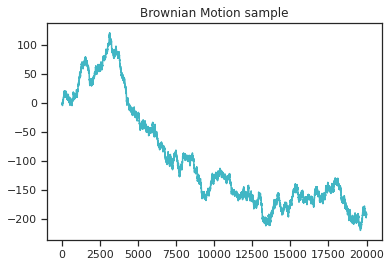

In [7]:
brownian_motion_ts = np.cumsum(rng.normal(size=20000))
plt.plot(brownian_motion_ts)
plt.title("Brownian Motion sample")
plt.show()

Убедимся, что функция `mf_dfa` работает

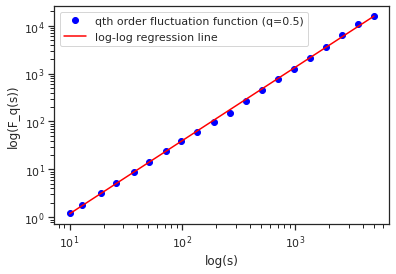

DFA exponent for this Brownian motion sample: 1.528067158462643


In [8]:
bm_H = mf_dfa(brownian_motion_ts, s_vals=20, q=0.5, debug_plot=True)
print("DFA exponent for this Brownian motion sample: {}".format(bm_H))

На 5 случайных реализациях Броуновского движения (10000 точек в каждой) посмотрим, как меняется скейлинговый показатель в зависимости от параметра $q$.

Ожидаемый результат: ~1.5 (+/- 0.2)

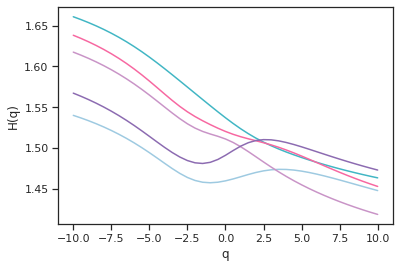

In [9]:
q_range = np.linspace(-10, 10, 41)          # набор значений q можно менять
for i in trange(5, desc="Brownian motion"): # 'trange' из tqdm делает красивый индикатор выполнения
    brownian_motion_ts = np.cumsum(rng.normal(size=10000))
    plt.plot(q_range, [mf_dfa(brownian_motion_ts, q=qi) for qi in q_range])
plt.xlabel("q")
plt.ylabel("H(q)")
plt.show()

Пора испытать на каком-нибудь реальном примере

In [10]:
# TODO: загрузите свой временной ряд (желательно, чтобы в нём было >5000 точек)
#data = pd.read_csv("FRB_H10.csv", parse_dates=['date'], na_values='ND')
# и запустите для него функцию mf_dfa для разных значений q
# (как положительных, так и отризательных).
# Является ли этот ряд мультифрактальным?
# (6 баллов)

data = pd.read_csv("FRB_H10.csv", parse_dates=['date']) 
data = data[data['rate'] != 'ND']
y = data['rate']
y = np.asarray(data['rate'])
ts = []
for index in range(len(y)):
  ts.append(float(y[index]))


q_range = np.unique(np.concatenate((np.arange(-10., 10., 1.),np.arange(-5., 5., .5))))  # набор значений q можно выбрать другой
DFA_vals = [mf_dfa(ts, s_vals=20, p=1, q=qi) for qi in q_range]                         # параметры s_vals и p тоже можно варьировать

Визуализация результатов

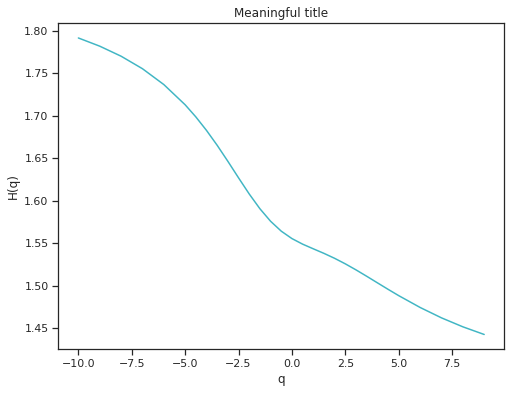

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(q_range, DFA_vals)
plt.xlabel("q")
plt.ylabel("H(q)")
plt.title("Meaningful title")
plt.show()

Вывод: данный ряд является мультифрактальным, так как обобщенный показатель Херста значительно различается при разных q
